# Plot Simulation Results

In [30]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import io
import zipfile

In [2]:
yields = pd.read_hdf('/tf/primo/data/simulation/extended_targets/callie_janelle.h5')
#dists = pd.read_hdf('/tf/primo/data/extended_targets/query_target_dists.h5')
dists = pd.read_hdf('/tf/primo/data/targets/query_target_dists.h5')

In [3]:
df = yields.join(dists['callie_janelle'].rename('euclidean_distance'))

In [4]:
# Yield predictor here is a differentiable DNA hybridization yield predictor (originally learned from the Nupack simulator). Represented in brown to the right of the one-hot box.
![big](../../documentation/similarity_search_schematic.jpg)df[df['euclidean_distance'] < 75]

/bin/sh: 1: Syntax error: word unexpected (expecting ")")


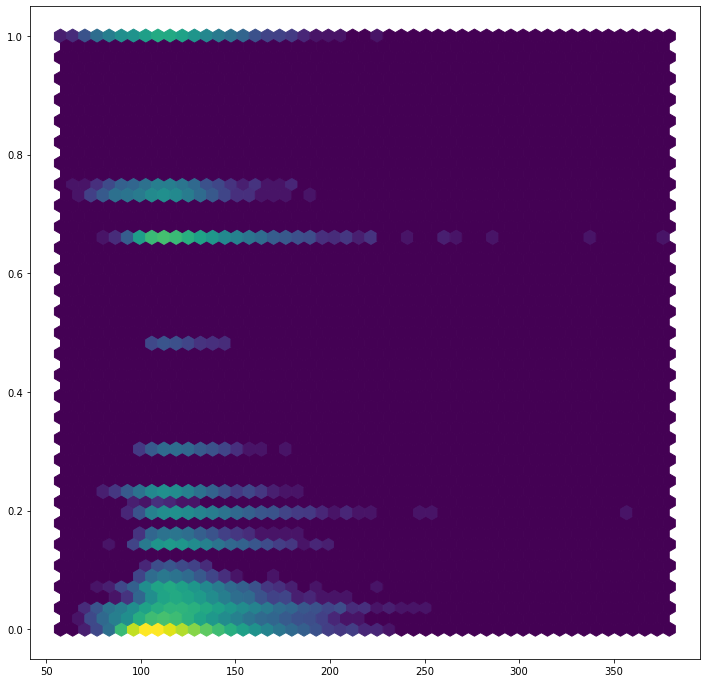

In [5]:
  [0.25,   0.25,   0.25,   0.25,  ],# Color here represents density.
# For more info on Hexbins, check out https://holypython.com/python-visualization-tutorial/creating-hexbin-charts/
plt.figure(figsize=(12,12))
plt.hexbin(df.euclidean_distance, df.duplex_yield, gridsize=50, bins='log')

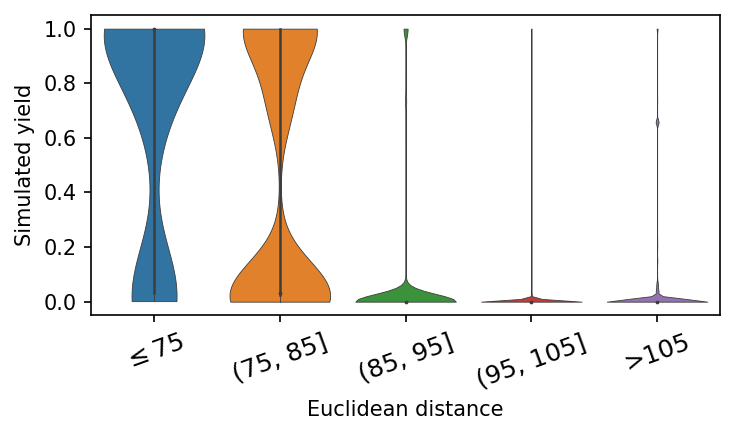

In [6]:
thresholds = [75, 85, 95, 105]
bin_labels = np.array(
    ["$\leq%d$" % thresholds[0]]
    + ["(%d, %d]" % (a,b) for (a,b) in zip(thresholds,thresholds[1:])]
    + [">%d" % thresholds[-1]]
)

plt.figure(figsize = (5, 3), dpi=150)
(lambda data:
    sns.violinplot(

        x='dist_bin',
        y='duplex_yield',
        data=data,
        linewidth=0.4,
        fliersize=0.5,
        cut=0.0,
        scale='width',
        order = bin_labels
    )
)(
    df
    .assign(
        dist_bin = lambda df: bin_labels[np.digitize(df.euclidean_distance, thresholds, right=True)]
    )
)
plt.xlabel("Euclidean distance")
plt.xticks(rotation=20)
[label.set_fontsize(12) for label in plt.gca().get_xticklabels()]
plt.ylabel("Simulated yield")
plt.tight_layout()

In [7]:
def nn_recall(scores, distances, k=10, n_thresholds=500, thresholds=None):
    # Nearest-neighbor recall.
    if thresholds is None:
        thresholds = np.linspace(scores.min(), scores.max(), n_thresholds)
        thresholds[0] = (thresholds[0] + thresholds[1])/2
        
    retrieved = scores >= thresholds.reshape(-1,1)
    p_retrieved = retrieved.mean(1)
    
    neighbors = distances.argsort()[:k]
    
    nn_recall = retrieved[:, neighbors].mean(1)
    
    return nn_recall, p_retrieved, thresholds

def nn_recall_discrete(scores, distances, k=100, n_thresholds=500):
    thresholds = np.unique(np.logspace(0, np.log10(scores.max()), n_thresholds).astype(int))
    
    retrieved = scores >= thresholds.reshape(-1,1)
    p_retrieved = retrieved.mean(1)
    
    neighbors = distances.argsort()[:k]
    
    nn_recall = retrieved[:, neighbors].mean(1)
    
    return nn_recall, p_retrieved, thresholds

def plot_baselines(nn_k, n_targets, plt_fn = lambda ax: ax.loglog):
    def plot(ax):
        ax_plot = plt_fn(ax)
        unif = np.linspace(0,1,100)
        ax_plot(unif, unif, alpha=0.2, ls='--', color='black', label='Chance')
        ax_plot(unif, unif * nn_k/n_targets, alpha=0.2, ls='-.', color='black', label='Oracle')
    return plot

In [8]:
n,p,t = nn_recall(
    df.duplex_yield.values/df.duplex_yield.max(),
    df.euclidean_distance.values,
    k=100,
    thresholds=1-np.logspace(-14, 0, 100)
)

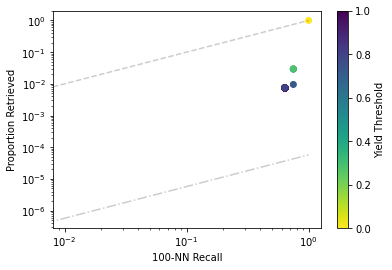

In [9]:
plt.scatter(n,p,c=t, cmap=plt.cm.viridis_r)
plot_baselines(100, len(df))(plt.gca())
plt.xlabel("100-NN Recall")
plt.ylabel("Proportion Retrieved")
plt.colorbar(label="Yield Threshold")

In [10]:
list(t)

[0.99999999999999,
 0.9999999999999861,
 0.9999999999999808,
 0.9999999999999735,
 0.9999999999999633,
 0.999999999999949,
 0.9999999999999295,
 0.9999999999999023,
 0.9999999999998647,
 0.9999999999998126,
 0.9999999999997405,
 0.9999999999996406,
 0.9999999999995023,
 0.9999999999993108,
 0.9999999999990454,
 0.9999999999986781,
 0.9999999999981692,
 0.9999999999974646,
 0.9999999999964888,
 0.9999999999951374,
 0.9999999999932658,
 0.999999999990674,
 0.9999999999870846,
 0.9999999999821135,
 0.9999999999752293,
 0.9999999999656953,
 0.9999999999524919,
 0.9999999999342066,
 0.9999999999088838,
 0.9999999998738143,
 0.9999999998252471,
 0.9999999997579871,
 0.9999999996648398,
 0.9999999995358411,
 0.9999999993571926,
 0.9999999991097849,
 0.9999999987671533,
 0.9999999982926474,
 0.9999999976355106,
 0.9999999967254508,
 0.9999999954651215,
 0.9999999937197086,
 0.9999999913025099,
 0.9999999879549646,
 0.9999999833189946,
 0.999999976898703,
 0.9999999680073286,
 0.999999955693785

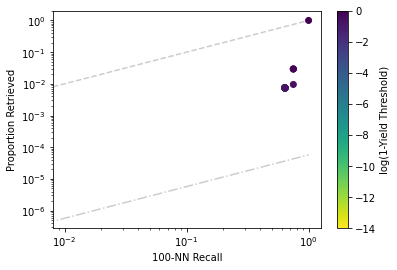

In [11]:
plt.scatter(n,p,c=np.log10(1-t), cmap=plt.cm.viridis_r)
plot_baselines(100, len(df))(plt.gca())
plt.xlabel("100-NN Recall")
plt.ylabel("Proportion Retrieved")
plt.colorbar(label="log(1-Yield Threshold)")

In [12]:
np.log10(1-t)

array([-14.00034726, -13.85767976, -13.71654367, -13.57619187,
       -13.43476178, -13.29277708, -13.15181604, -13.0101071 ,
       -12.86858606, -12.72721733, -12.58593106, -12.44444707,
       -12.30302103, -12.16163806, -12.02019233, -11.87878742,
       -11.73736911, -11.59595072, -11.4545455 , -11.31313549,
       -11.171716  , -11.03030531, -10.88889058, -10.74747536,
       -10.606061  , -10.46464675, -10.32323226, -10.18181786,
       -10.04040428,  -9.89898976,  -9.75757566,  -9.61616157,
        -9.47474752,  -9.33333329,  -9.19191916,  -9.05050503,
        -8.90909092,  -8.76767678,  -8.62626263,  -8.48484848,
        -8.34343435,  -8.20202021,  -8.06060606,  -7.91919192,
        -7.77777778,  -7.63636364,  -7.49494949,  -7.35353535,
        -7.21212121,  -7.07070707,  -6.92929293,  -6.78787879,
        -6.64646465,  -6.50505051,  -6.36363636,  -6.22222222,
        -6.08080808,  -5.93939394,  -5.7979798 ,  -5.65656566,
        -5.51515152,  -5.37373737,  -5.23232323,  -5.09

In [13]:
df.sort_values('duplex_yield', ascending=False)

,duplex_yield,euclidean_distance
ac6f9ddef55a8ab0,1.0000,113.686752
2b37d2ce41cdd184,1.0000,124.680733
1566e97a3c77fb9b,1.0000,115.728912
98ca3eea0a5c5ad0,1.0000,98.635719
c213eaa5aa9608ab,1.0000,121.572235
...,...,...
5b83703d5a885476,0.0002,102.093102
5b835c8b5b166d03,0.0002,104.266701
5b833ce2a32faf46,0.0002,110.205154
5b831927ce791063,0.0002,104.741447


In [27]:
df.loc['ac6f9ddef55a8ab0']

duplex_yield            1.000000
euclidean_distance    113.686752
Name: ac6f9ddef55a8ab0, dtype: float64

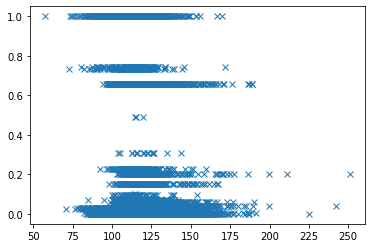

In [14]:
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 2_000_000
plt.figure()
subset = df.sample(100000)
plt.plot(subset['euclidean_distance'], subset['duplex_yield'], 'x')

In [15]:
from PIL import Image

In [16]:
# The items with top 'k' duplex yields.
k_top = 100
tops = df.sort_values('duplex_yield', ascending=False)[:k_top]

In [28]:
def get_image_from_zip(imgid):
    zip_path = f'/tf/open_images/targets/images/train_{imgid[:1]}.zip'
    zip_file = zipfile.ZipFile(zip_path, 'r')
    img_file = zip_file.read(f"train_{imgid[:1]}/{imgid}.jpg")
    return Image.open(io.BytesIO(img_file))

KeyboardInterrupt: 

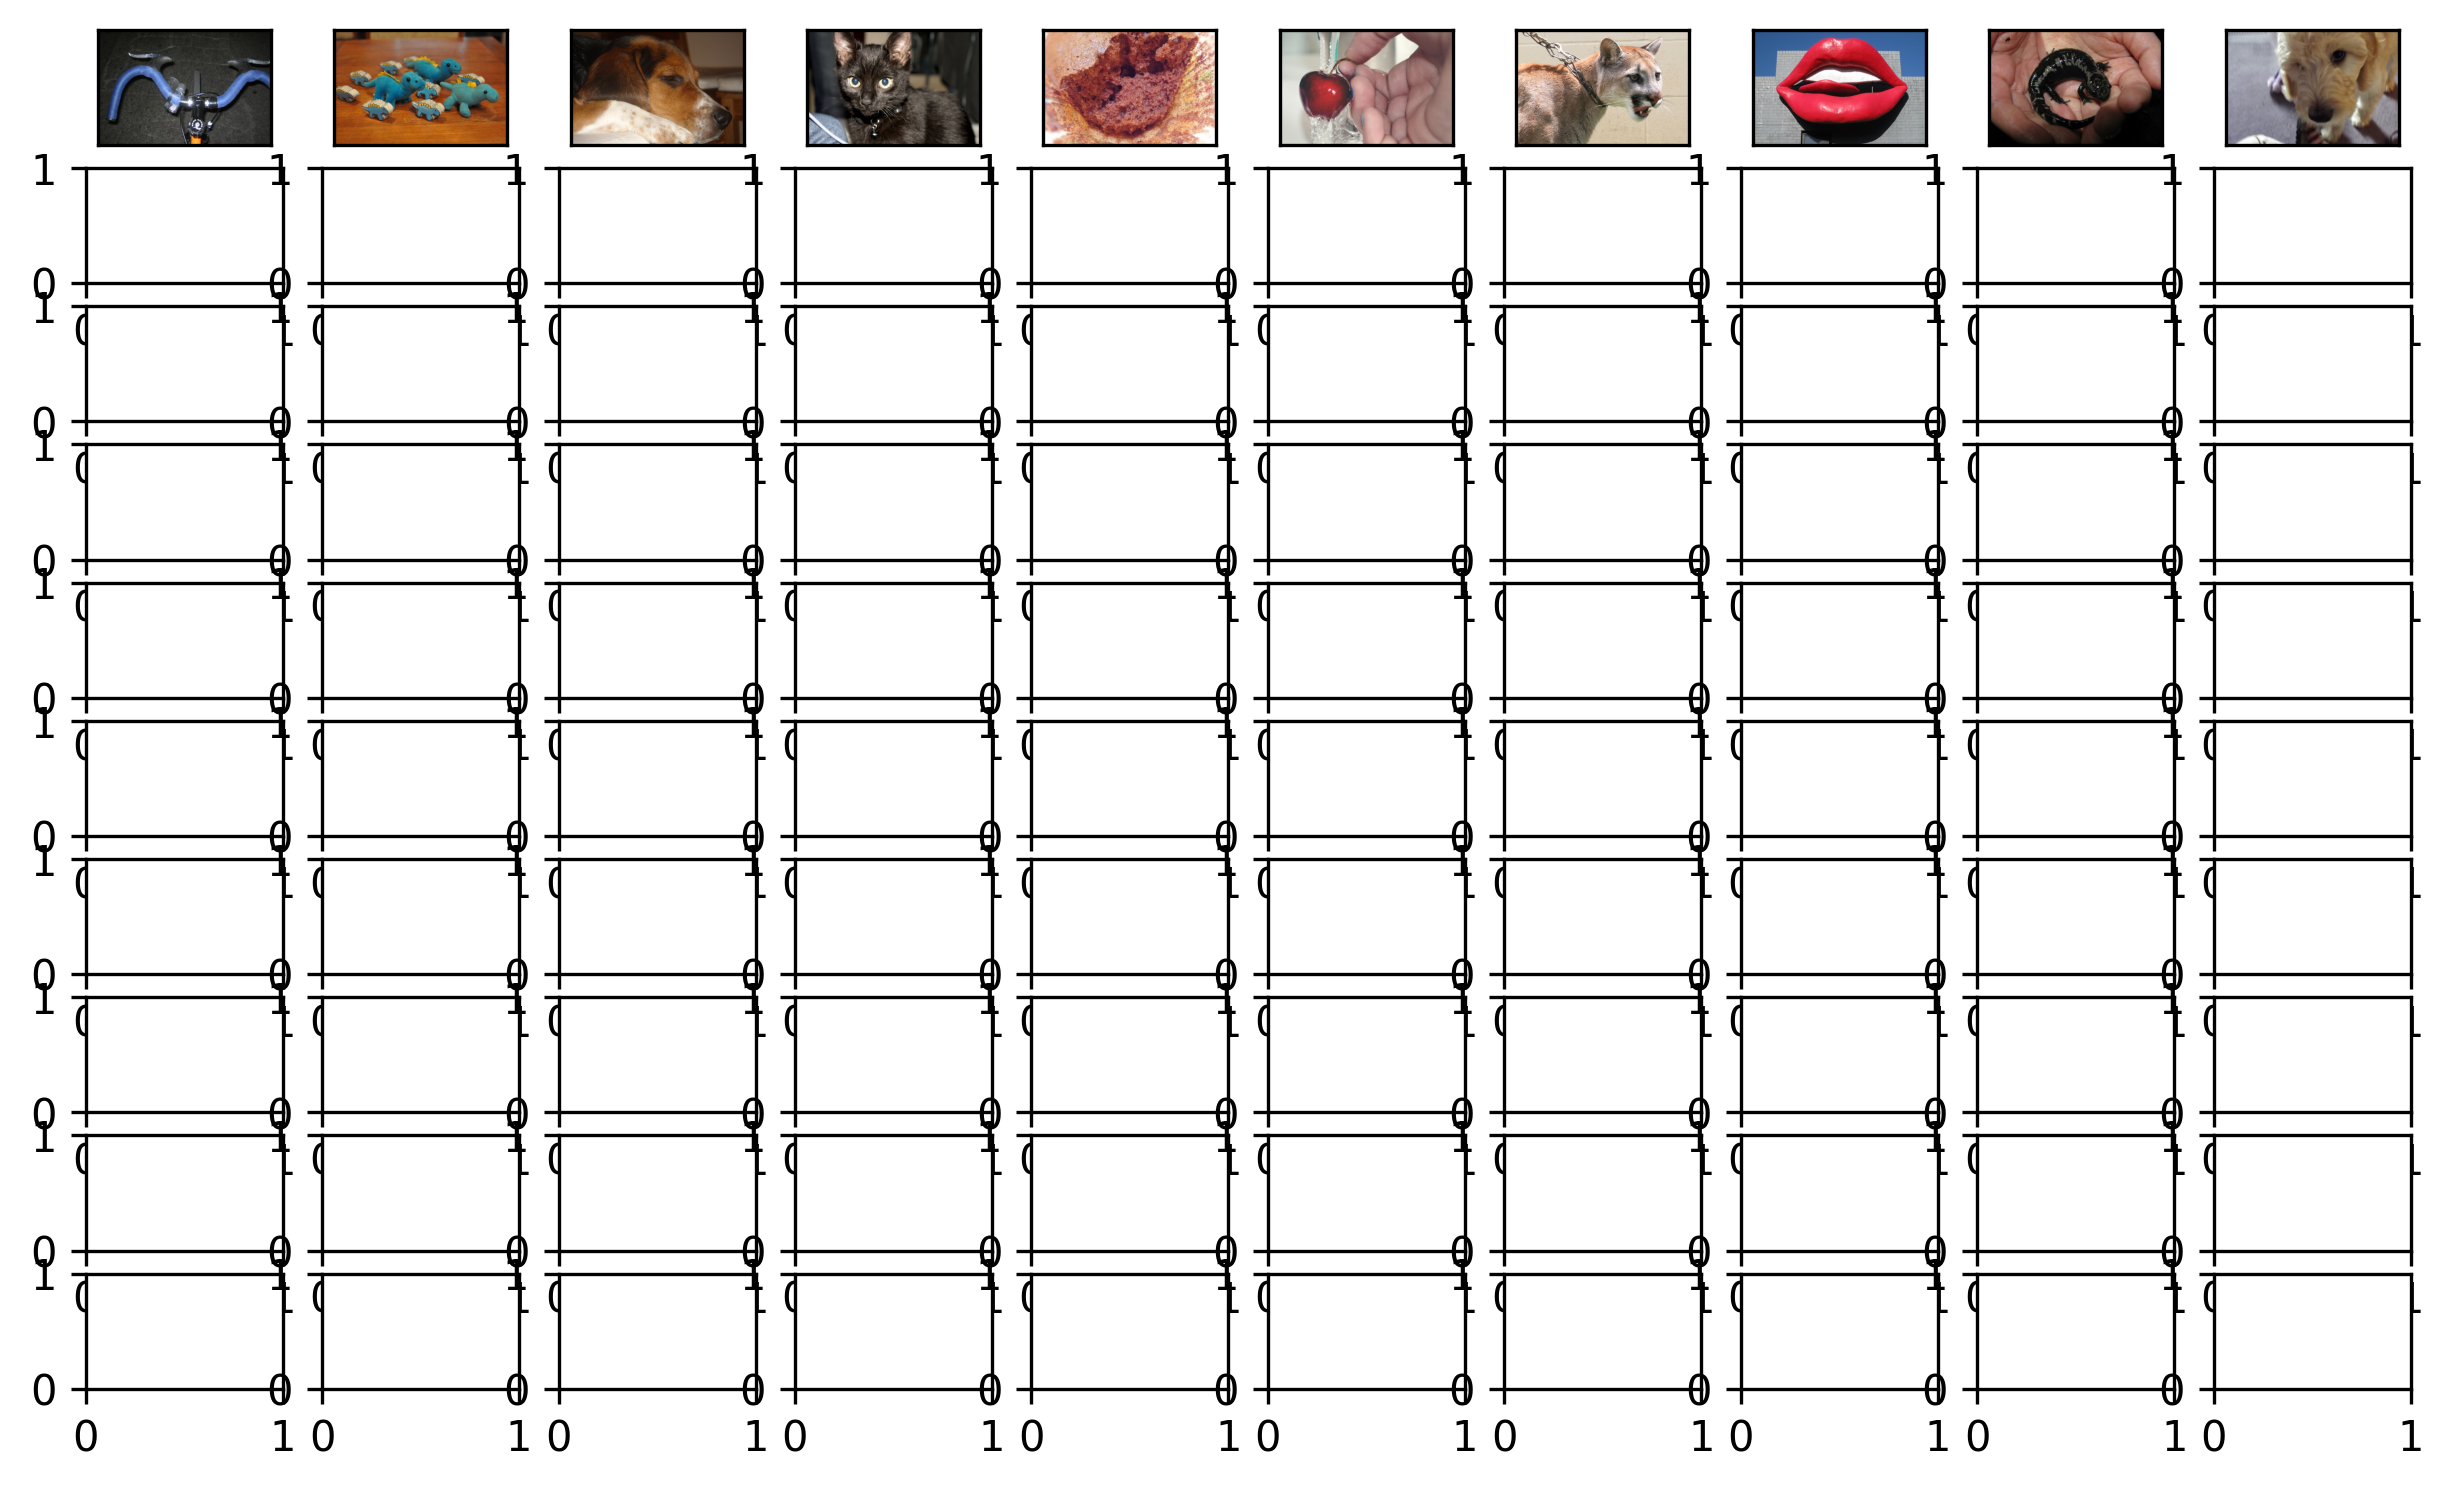

In [33]:
rows = 10
cols = 10
fig, axarr = plt.subplots(rows, cols, figsize = (10,6), dpi=300)
# Plot the top number of highest simulayed yield target-query yields (the number plotted will be rows * cols). 
for ix, ax in enumerate(axarr.flat):
    if ix < len(tops):
        imgid = tops.index[ix]
#         img = Image.open('/tf/open_images/extended_targets/images/%s/%s.jpg' % (imgid[:2], imgid))
        img = get_image_from_zip(imgid)
        new_height = img.width / 1.5
        crop = img.crop([0,img.height/2 - new_height/2,img.width,img.height/2 + new_height/2])
        ax.imshow(crop)
    ax.set_xticks(())
    ax.set_yticks(())
plt.tight_layout()
# plt.savefig('/tf/primo/fig.pdf')

In [36]:
tops

,duplex_yield,euclidean_distance
ac6f9ddef55a8ab0,1.0,113.686752
2b37d2ce41cdd184,1.0,124.680733
1566e97a3c77fb9b,1.0,115.728912
98ca3eea0a5c5ad0,1.0,98.635719
c213eaa5aa9608ab,1.0,121.572235
...,...,...
397af0020c31913c,1.0,121.056259
1592697c730a1c4e,1.0,115.970749
fdadc11bb70f24d6,1.0,116.708244
0541e537f1546842,1.0,112.107292


In [289]:
600 / 1.5

400.0